<a href="https://colab.research.google.com/github/molnaredom/asztro/blob/master/asztrologia_melytanulas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Structured data learning with TabTransformer

https://keras.io/examples/structured_data/tabtransformer/#introduction

In [10]:
pip install tensorflow-addons


In [11]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt


In [12]:
CSV_HEADER = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
)
train_data = pd.read_csv(train_data_url, header=None, names=CSV_HEADER)

test_data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
)
test_data = pd.read_csv(test_data_url, header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")


Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


In [13]:
test_data = test_data[1:]
test_data.income_bracket = test_data.income_bracket.apply(
    lambda value: value.replace(".", "")
)


In [14]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False, header=False)
test_data.to_csv(test_data_file, index=False, header=False)


In [15]:
# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = [
    "age",
    "education_num",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
]
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "workclass": sorted(list(train_data["workclass"].unique())),
    "education": sorted(list(train_data["education"].unique())),
    "marital_status": sorted(list(train_data["marital_status"].unique())),
    "occupation": sorted(list(train_data["occupation"].unique())),
    "relationship": sorted(list(train_data["relationship"].unique())),
    "race": sorted(list(train_data["race"].unique())),
    "gender": sorted(list(train_data["gender"].unique())),
    "native_country": sorted(list(train_data["native_country"].unique())),
}
# Name of the column to be used as instances weight.
WEIGHT_COLUMN_NAME = "fnlwgt"
# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + [WEIGHT_COLUMN_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]
# The name of the target feature.
TARGET_FEATURE_NAME = "income_bracket"
# A list of the labels of the target features.
TARGET_LABELS = [" <=50K", " >50K"]


In [16]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.2
BATCH_SIZE = 265
NUM_EPOCHS = 15

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.


In [17]:
target_label_lookup = layers.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def prepare_example(features, target):
    target_index = target_label_lookup(target)
    weights = features.pop(WEIGHT_COLUMN_NAME)
    return features, target_index, weights


def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(prepare_example, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    return dataset.cache()


In [18]:
def run_experiment(
    model,
    train_data_file,
    test_data_file,
    num_epochs,
    learning_rate,
    weight_decay,
    batch_size,
):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(
        train_dataset, epochs=num_epochs, validation_data=validation_dataset
    )
    print("Model training finished")

    _, accuracy = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

    return history


In [19]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs


In [20]:
def encode_inputs(inputs, embedding_dims):

    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:

            # Get the vocabulary of the categorical feature.
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]

            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = layers.StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int",
            )

            # Convert the string input values into integer indices.
            encoded_feature = lookup(inputs[feature_name])

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(encoded_feature)
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:

            # Use the numerical features as-is.
            numerical_feature = tf.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    return encoded_categorical_feature_list, numerical_feature_list


In [21]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):

    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer),
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)


Total model weights: 109629


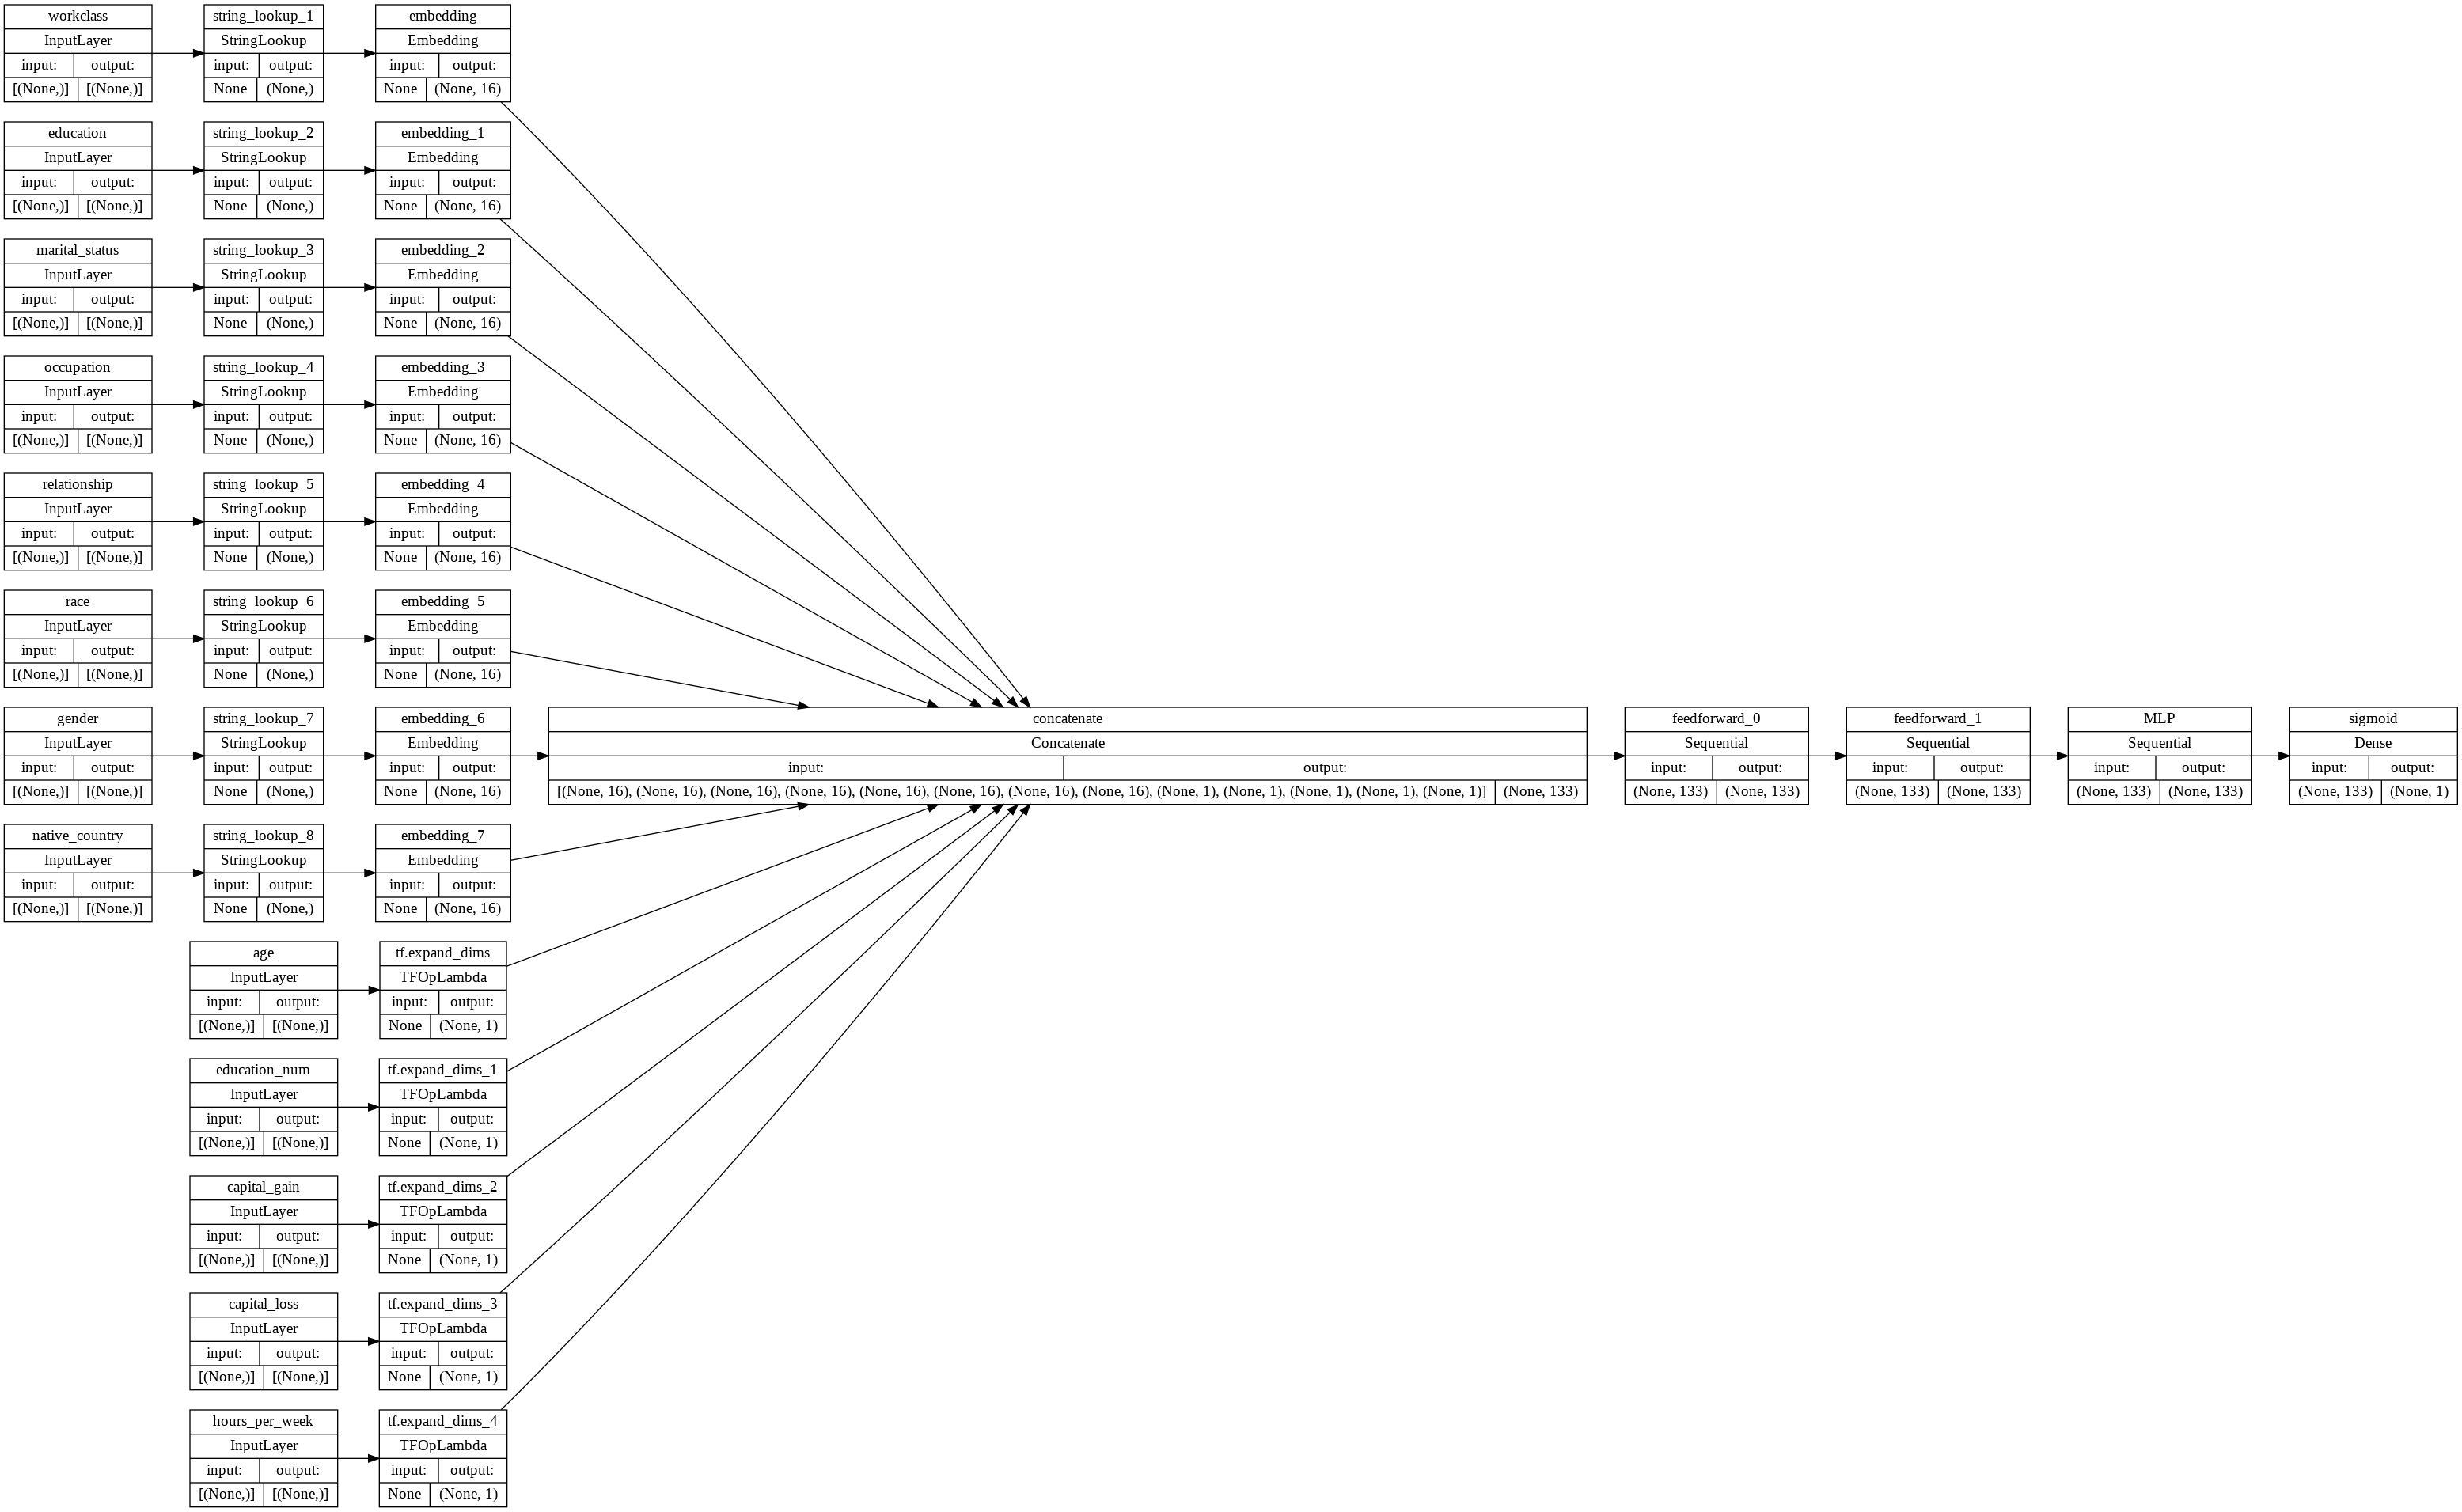

In [22]:
def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Concatenate all features.
    features = layers.concatenate(
        encoded_categorical_feature_list + numerical_feature_list
    )
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1]]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", baseline_model.count_params())
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")


In [23]:
history = run_experiment(
    model=baseline_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)


Start training the model...
Epoch 1/15
123/123 [==============================] - 9s 46ms/step - loss: 112604.9219 - accuracy: 0.7417 - val_loss: 93918.6875 - val_accuracy: 0.7638
Epoch 2/15
123/123 [==============================] - 4s 34ms/step - loss: 92462.0859 - accuracy: 0.7665 - val_loss: 73368.4453 - val_accuracy: 0.8032
Epoch 3/15
123/123 [==============================] - 4s 33ms/step - loss: 76750.9297 - accuracy: 0.7921 - val_loss: 69927.1797 - val_accuracy: 0.7927
Epoch 4/15
123/123 [==============================] - 4s 34ms/step - loss: 72946.1094 - accuracy: 0.8012 - val_loss: 69221.8828 - val_accuracy: 0.7882
Epoch 5/15
123/123 [==============================] - 4s 35ms/step - loss: 70668.9922 - accuracy: 0.8062 - val_loss: 67590.2656 - val_accuracy: 0.8087
Epoch 6/15
123/123 [==============================] - 4s 33ms/step - loss: 69338.2344 - accuracy: 0.8076 - val_loss: 67585.6875 - val_accuracy: 0.8073
Epoch 7/15
123/123 [==============================] - 4s 35ms/ste

# Órák


Bias: 
minden adatot eltol valamennyivel
lehetove teszi hogy tanulhato modon eltoljuk az ertekeket ha valmai nagyon kimagaslo modon jelenne meg

# Classification with Gated Residual and Variable Selection Networks

https://keras.io/examples/structured_data/classification_with_grn_and_vsn/

In [2]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [3]:
# Column names.
CSV_HEADER = [
    "age",
    "class_of_worker",
    "detailed_industry_recode",
    "detailed_occupation_recode",
    "education",
    "wage_per_hour",
    "enroll_in_edu_inst_last_wk",
    "marital_stat",
    "major_industry_code",
    "major_occupation_code",
    "race",
    "hispanic_origin",
    "sex",
    "member_of_a_labor_union",
    "reason_for_unemployment",
    "full_or_part_time_employment_stat",
    "capital_gains",
    "capital_losses",
    "dividends_from_stocks",
    "tax_filer_stat",
    "region_of_previous_residence",
    "state_of_previous_residence",
    "detailed_household_and_family_stat",
    "detailed_household_summary_in_household",
    "instance_weight",
    "migration_code-change_in_msa",
    "migration_code-change_in_reg",
    "migration_code-move_within_reg",
    "live_in_this_house_1_year_ago",
    "migration_prev_res_in_sunbelt",
    "num_persons_worked_for_employer",
    "family_members_under_18",
    "country_of_birth_father",
    "country_of_birth_mother",
    "country_of_birth_self",
    "citizenship",
    "own_business_or_self_employed",
    "fill_inc_questionnaire_for_veteran's_admin",
    "veterans_benefits",
    "weeks_worked_in_year",
    "year",
    "income_level",
]

data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census-income.data.gz"
data = pd.read_csv(data_url, header=None, names=CSV_HEADER)

test_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census-income.test.gz"
test_data = pd.read_csv(test_data_url, header=None, names=CSV_HEADER)

print(f"Data shape: {data.shape}")
print(f"Test data shape: {test_data.shape}")


Data shape: (199523, 42)
Test data shape: (99762, 42)


In [4]:
data["income_level"] = data["income_level"].apply(
    lambda x: 0 if x == " - 50000." else 1
)
test_data["income_level"] = test_data["income_level"].apply(
    lambda x: 0 if x == " - 50000." else 1
)


In [5]:
random_selection = np.random.rand(len(data.index)) <= 0.85
train_data = data[random_selection]
valid_data = data[~random_selection]


In [6]:
train_data_file = "train_data.csv"
valid_data_file = "valid_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False, header=False)
valid_data.to_csv(valid_data_file, index=False, header=False)
test_data.to_csv(test_data_file, index=False, header=False)


In [7]:
# Target feature name.
TARGET_FEATURE_NAME = "income_level"
# Weight column name.
WEIGHT_COLUMN_NAME = "instance_weight"
# Numeric feature names.
NUMERIC_FEATURE_NAMES = [
    "age",
    "wage_per_hour",
    "capital_gains",
    "capital_losses",
    "dividends_from_stocks",
    "num_persons_worked_for_employer",
    "weeks_worked_in_year",
]
# Categorical features and their vocabulary lists.
# Note that we add 'v=' as a prefix to all categorical feature values to make
# sure that they are treated as strings.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    feature_name: sorted([str(value) for value in list(data[feature_name].unique())])
    for feature_name in CSV_HEADER
    if feature_name
    not in list(NUMERIC_FEATURE_NAMES + [WEIGHT_COLUMN_NAME, TARGET_FEATURE_NAME])
}
# All features names.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + list(
    CATEGORICAL_FEATURES_WITH_VOCABULARY.keys()
)
# Feature default values.
COLUMN_DEFAULTS = [
    [0.0]
    if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME, WEIGHT_COLUMN_NAME]
    else ["NA"]
    for feature_name in CSV_HEADER
]


In [8]:
from tensorflow.keras.layers import StringLookup


def process(features, target):
    for feature_name in features:
        if feature_name in CATEGORICAL_FEATURES_WITH_VOCABULARY:
            # Cast categorical feature values to string.
            features[feature_name] = tf.cast(features[feature_name], tf.dtypes.string)
    # Get the instance weight.
    weight = features.pop(WEIGHT_COLUMN_NAME)
    return features, target, weight


def get_dataset_from_csv(csv_file_path, shuffle=False, batch_size=128):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        shuffle=shuffle,
    ).map(process)

    return dataset


In [9]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs


In [10]:
def encode_inputs(inputs, encoding_size):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURES_WITH_VOCABULARY:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            # Create a lookup to convert a string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            index = StringLookup(
                vocabulary=vocabulary, mask_token=None, num_oov_indices=0
            )
            # Convert the string input values into integer indices.
            value_index = index(inputs[feature_name])
            # Create an embedding layer with the specified dimensions
            embedding_ecoder = layers.Embedding(
                input_dim=len(vocabulary), output_dim=encoding_size
            )
            # Convert the index values to embedding representations.
            encoded_feature = embedding_ecoder(value_index)
        else:
            # Project the numeric feature to encoding_size using linear transformation.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)
            encoded_feature = layers.Dense(units=encoding_size)(encoded_feature)
        encoded_features.append(encoded_feature)
    return encoded_features


In [11]:
class GatedLinearUnit(layers.Layer):
    def __init__(self, units):
        super(GatedLinearUnit, self).__init__()
        self.linear = layers.Dense(units)
        self.sigmoid = layers.Dense(units, activation="sigmoid")

    def call(self, inputs):
        return self.linear(inputs) * self.sigmoid(inputs)


In [12]:
class GatedResidualNetwork(layers.Layer):
    def __init__(self, units, dropout_rate):
        super(GatedResidualNetwork, self).__init__()
        self.units = units
        self.elu_dense = layers.Dense(units, activation="elu")
        self.linear_dense = layers.Dense(units)
        self.dropout = layers.Dropout(dropout_rate)
        self.gated_linear_unit = GatedLinearUnit(units)
        self.layer_norm = layers.LayerNormalization()
        self.project = layers.Dense(units)

    def call(self, inputs):
        x = self.elu_dense(inputs)
        x = self.linear_dense(x)
        x = self.dropout(x)
        if inputs.shape[-1] != self.units:
            inputs = self.project(inputs)
        x = inputs + self.gated_linear_unit(x)
        x = self.layer_norm(x)
        return x


In [13]:
class VariableSelection(layers.Layer):
    def __init__(self, num_features, units, dropout_rate):
        super(VariableSelection, self).__init__()
        self.grns = list()
        # Create a GRN for each feature independently
        for idx in range(num_features):
            grn = GatedResidualNetwork(units, dropout_rate)
            self.grns.append(grn)
        # Create a GRN for the concatenation of all the features
        self.grn_concat = GatedResidualNetwork(units, dropout_rate)
        self.softmax = layers.Dense(units=num_features, activation="softmax")

    def call(self, inputs):
        v = layers.concatenate(inputs)
        v = self.grn_concat(v)
        v = tf.expand_dims(self.softmax(v), axis=-1)

        x = []
        for idx, input in enumerate(inputs):
            x.append(self.grns[idx](input))
        x = tf.stack(x, axis=1)

        outputs = tf.squeeze(tf.matmul(v, x, transpose_a=True), axis=1)
        return outputs


In [14]:
def create_model(encoding_size):
    inputs = create_model_inputs()
    feature_list = encode_inputs(inputs, encoding_size)
    num_features = len(feature_list)

    features = VariableSelection(num_features, encoding_size, dropout_rate)(
        feature_list
    )

    outputs = layers.Dense(units=1, activation="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [15]:
learning_rate = 0.001
dropout_rate = 0.15
batch_size = 265
num_epochs = 20
encoding_size = 16

model = create_model(encoding_size)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
)


# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

print("Start training the model...")
train_dataset = get_dataset_from_csv(
    train_data_file, shuffle=True, batch_size=batch_size
)
valid_dataset = get_dataset_from_csv(valid_data_file, batch_size=batch_size)
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)
print("Model training finished.")

print("Evaluating model performance...")
test_dataset = get_dataset_from_csv(test_data_file, batch_size=batch_size)
_, accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")


Start training the model...
Epoch 1/20
641/641 [==============================] - 90s 103ms/step - loss: 258.7297 - accuracy: 0.9458 - val_loss: 235.6494 - val_accuracy: 0.9481
Epoch 2/20
641/641 [==============================] - 62s 96ms/step - loss: 233.1552 - accuracy: 0.9489 - val_loss: 231.4536 - val_accuracy: 0.9495
Epoch 3/20
641/641 [==============================] - 63s 98ms/step - loss: 228.8037 - accuracy: 0.9495 - val_loss: 225.9246 - val_accuracy: 0.9510
Epoch 4/20
641/641 [==============================] - 63s 98ms/step - loss: 226.2533 - accuracy: 0.9500 - val_loss: 225.2506 - val_accuracy: 0.9500
Epoch 5/20
363/641 [===============>..............] - ETA: 25s - loss: 220.3239 - accuracy: 0.9510

KeyboardInterrupt: ignored